# Petit projet de recréer le fonctionnement de RCNN (https://en.wikipedia.org/wiki/Region_Based_Convolutional_Neural_Networks)

In [1]:
%tensorflow_version 1.x # A inclure en cas de soucis de compatibilité

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x # A inclure en cas de soucis de compatibilité`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [2]:
############################ IMPORTATION DES LIBS #############################

import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

Using TensorFlow backend.


In [3]:
##################### INTERSERCTION OVER UNION METRIC #########################

def get_IoU(box_predict, box_truth):
    
    assert box_predict['x1'] < box_predict['x2']
    assert box_predict['y1'] < box_predict['y2']
    assert box_truth['x1']   < box_truth['x2']
    assert box_truth['y1']   < box_truth['y2']
    
    x_left   = max(box_predict['x1'], box_truth['x1'])
    y_top    = max(box_predict['y1'], box_truth['y1'])
    x_right  = min(box_predict['x2'], box_truth['x2'])
    y_bottom = min(box_predict['y2'], box_truth['y2'])
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (box_predict['x2'] - box_predict['x1']) * (box_predict['y2'] - box_predict['y1'])
    bb2_area = (box_truth['x2'] - box_truth['x1']) * (box_truth['y2'] - box_truth['y1'])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    
    assert iou >= 0.0
    assert iou <= 1.0
    
    return iou
#FIN

- Petit test de la fonction

In [4]:
bb1 = {'x1' : 0.5, 'y1' : 1.5, 'x2' : 2.5, 'y2' : 4.5}
bb2 = {'x1' : 1, 'y1' : 1, 'x2' : 3, 'y2' : 5}
print(get_IoU(bb1, bb2))


0.47368421052631576


- Selective Search

In [5]:
############################ SELECTIVE SEARCH #################################

# Importé de CV2.

selective_search = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [6]:
train_images=[]
train_labels=[]

path = os.getcwd()
print(path)

/content


In [7]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [8]:
%ls /gdrive/'My Drive'

 Airplanes_Annotations/   DeepLearningCV/     ML/           Spark/
 Airplanes_Images/        Faster-RCNN.ipynb   Modeles/      zebre_04.jpg
'Colab Notebooks'/        haar_cascade/       NeuralNets/
 Compte-AWS-001           Images/             NLP/


In [9]:
# %rm -r /gdrive/'My Drive'/*

In [10]:
for num_i, filename_i in enumerate(os.listdir('/gdrive/My Drive/Airplanes_Images')):
    
    #print(num_i, image_i.lower())
    
        
    if filename_i.lower().startswith("airplane"):
            
            print(num_i, filename_i)
            
            image = cv2.imread('/gdrive/My Drive/Airplanes_Images/' + filename_i)
            
            df = pd.read_csv('/gdrive/My Drive/Airplanes_Annotations/' + filename_i.replace('jpg', 'csv'))
            
            # Récupérer les valeurs (x1, x2, y1, y2) pour chaque avions labélisé
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            
            # Set la variable interne correspondant à l'image dans l'obket selective_search a celle de notre image
            selective_search.setBaseImage(image)
            
            # Soumettre l'image actuelle à selective search and getting proposed regions = 2000
            selective_search.switchToSelectiveSearchFast()
            ssresults = selective_search.process()

            # Copier l'image
            imout = image.copy()
            
            # Iérer sur tout les résultat passé par selective search 
            # et calculer IOU of the proposed region and annotated region 
            # using the get_iou() 
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e, result in enumerate(ssresults):
                
                if e < 2000 and flag == 0:
                    
                    # Pour chaque zone/bounding box annotés de l'image (ground truth)
                    for gtval in gtvalues:
                        
                        # Récupérer hauteur et largeur et base (x,y), proposé par selective_search
                        x, y, w, h = result
                        
                        # Calculer Intersection sur Union entre ce que me propose selective search et le réel
                        iou = get_IoU(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        
                        # collecter un max de 30 negative sample (i.e. background)
                        # 30 positive sample (i.e. airplane) from one image.
                        if counter < 30:
                            if iou > 0.70: # Bonne détéction
                                
                                # Concerver une portion de l'image correspondant à la zone prédite
                                tmp_image = imout[y:y+h,x:x+w]
                                
                                # Retailler image en 224 x 224
                                resized = cv2.resize(tmp_image, (224,224), interpolation = cv2.INTER_AREA)
                                
                                # L'ajouter au train
                                train_images.append(resized)
                                
                                # Objet détecté = label 1
                                train_labels.append(1)
                                
                                # Incrémenter le compteur d'objet découvert
                                counter += 1
                        else :
                            fflag =1
                        if falsecounter < 30:
                            if iou < 0.3:
                                tmp_image = imout[y:y+h,x:x+w]
                                resized = cv2.resize(tmp_image, (224,224), interpolation = cv2.INTER_AREA)
                                
                                # L'ajouter au train
                                train_images.append(resized)
                                
                                # Objet non détecté = label 0
                                train_labels.append(0)
                                
                                # Incrémenter le compteur background
                                falsecounter += 1
                        else :
                            bflag = 1
                            
                        """if num_i > 0:
                            break"""
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
        
#

18 airplane_002.jpg
19 airplane_010.jpg
20 airplane_007.jpg
inside
21 airplane_009.jpg
22 airplane_005.jpg
inside
23 airplane_008.jpg
24 airplane_006.jpg
25 airplane_001.jpg
inside
26 airplane_004.jpg
inside
27 airplane_003.jpg
28 airplane_011.jpg
29 airplane_012.jpg
inside
30 airplane_021.jpg
31 airplane_013.jpg
32 airplane_015.jpg
33 airplane_014.jpg
34 airplane_017.jpg
35 airplane_016.jpg
36 airplane_022.jpg
37 airplane_020.jpg
38 airplane_018.jpg
39 airplane_019.jpg
40 airplane_023.jpg
41 airplane_024.jpg
42 airplane_033.jpg
43 airplane_032.jpg
44 airplane_030.jpg
45 airplane_026.jpg
46 airplane_027.jpg
47 airplane_028.jpg
48 airplane_031.jpg
49 airplane_025.jpg
50 airplane_029.jpg
51 airplane_034.jpg
52 airplane_035.jpg
53 airplane_036.jpg
54 airplane_039.jpg
55 airplane_038.jpg
56 airplane_037.jpg
57 airplane_045.jpg
inside
58 airplane_043.jpg
59 airplane_042.jpg
60 airplane_041.jpg
inside
61 airplane_040.jpg
62 airplane_044.jpg
63 airplane_046.jpg
64 airplane_047.jpg
65 airplane

- Voir une région proposée

Text(0.5, 1.0, 'Région Proposé')

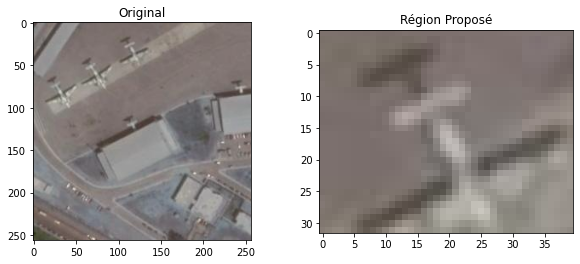

In [11]:
fig, axs = plt.subplots(1, 2, figsize = (10, 4))
axs[0].imshow(image)
axs[0].set_title("Original")
axs[1].imshow(tmp_image)
axs[1].set_title("Région Proposé")

In [12]:
#♦ Construire les jeux de train/test
        
from sklearn.model_selection import train_test_split
train_images = np.array(train_images)
train_labels = np.array(train_labels)

X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Encodage des sorties
#from keras.utils.np_utils import to_categorical
#y_train = to_categorical(y_train, 2)
#y_test  = to_categorical(y_test, 2)

- Vizualiser une image du Train-Set

1

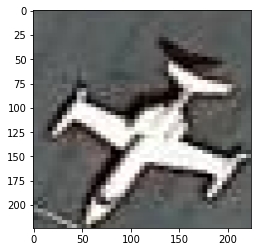

In [13]:
plt.imshow(X_train[8])
X_train.shape
y_train[8]

In [14]:
######################### DEFINIR LE MODELE ###################################
                        
from keras.applications.vgg16 import VGG16

## Création AVEC couche FC à la fin
model2 = VGG16(weights = 'imagenet', 
               include_top = True)

#2 Voir l'architecture du modèle et le nom des couches
print(model2.summary())

#3 Version plus graphique
from keras.utils.vis_utils import plot_model
plot_model(model2, to_file='vgg2.png')

#4 Figer les poids de la partie réseau convolutionel
for l in model2.layers[:19]:
   print(l.name)
   l.trainable = False

# Getting output tensor of the last VGG layer that we want to include
fc2 = model2.layers[-2].output

# Remove Conv layer after : fc2, on commence par la fin jusqu'à fc2
for index_layer in range(len(model2.layers)-1, 0 , -1):

    if model2.layers[index_layer].name == 'fc2':
        break
    else:
        model2.layers.pop()

#5 Rajouter un nouvelle couche FC
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam
prediction_layer = Dense(units = 1, activation = 'sigmoid') (fc2)

# Combiner le 2 modèles ....
from keras.models import Model
new_model = Model(inputs = [model2.input], outputs = [prediction_layer])
print(new_model.summary())

# Compiler le modèle
new_model.compile(optimizer = Adam(0.001),
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

553467904/553467096 [==============================] - 26s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 11

- Charger un modèle

In [15]:
if "RCNN_w.h5" in os.listdir("/gdrive/My Drive/Modeles/"):
  new_model.load_weights("/gdrive/My Drive/Modeles/RCNN_w.h5")
else:
  print("Pas de modèle enregistré !-")

Pas de modèle enregistré !-


- Callbacks

In [18]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

model_path = "/gdrive/My Drive/Modeles/RCNN_w.h5"
checkpoint = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

callbacks = [checkpoint, earlystop]

**Entrainement sans Data Augmentation**

In [ ]:
new_model.fit(X_train, y_train, batch_size=250, epochs=10, verbose=1, callbacks=callbacks, validation_split=0.1)

**Entrainement avec Data Augmentation**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# Génaration d'image avec transformation
train_datagen = ImageDataGenerator(
        rescale=1./255, # changer échelle  de la valeur de chaque pixel
        shear_range=0.2, # transformation d'angle
        zoom_range=0.2,
        horizontal_flip=True) # rettouner image horizontalement

test_datagen = ImageDataGenerator(
        rescale=1./255)

training_set_generator = train_datagen.flow(X_train, y_train, batch_size = 32)        # Lot de 32 observations avant gradient

test_set_generator = test_datagen.flow(x_test, y_test, batch_size = 32)

# Entraine le modèle et mesure performances
classifieur.fit_generator(
        training_set_generator,
        steps_per_epoch=250, # nb x on va réajuster les poids (8000 images dans 32 -> 8000/32)
        epochs=25,
        callbacks = callbacks,
        validation_data=test_set_generator,
        validation_steps=63) # pareil "steps_per_epoch" mais pour le jeu de TEST (2000/32)

**Prédiction**

In [ ]:
# Check sortie modèle
image = X_train[8]
out = new_model.predict(image)

print(out)

In [ ]:
# Récupérer une image de test non-utilisé
image = cv2.imread('/gdrive/My Drive/Airplanes_Images/Planes12.jpg')

# Appliquer selective search sur cette image
selective_search.setBaseImage(imgage)
selective_search.switchToSelectiveSearchFast()
ssresults = selective_search.process()

imout = image.copy()

for e,result in enumerate(ssresults):
  if e < 2000:
    x,y,w,h = result
    timage = imout[y:y+h,x:x+w]
    resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
    img = np.expand_dims(resized, axis=0)
    out = new_model.predict(img)
    """
      If the output of the model says the region to be a foreground image (i.e. airplane image) and 
      if the confidence is above the defined threshold then create bounding box on the original image 
      on the coordinate of the proposed region by selective search
    """
  if out[0][0] > 0.70:
    # Dessiner un réctangle sur l'image pour cette classe
    cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)

    # Ajouter la valeur de probabilité calculé 
    cv2.putText(imout, str(out[0][0]), ((x+w+0.5, y+h+0.5)), cv2.FONT_HERSHEY_SIMPLEX, 2, 255)

plt.figure()
plt.imshow(imout)
plt.set_title()

In [ ]:
z=0
for e,i in enumerate(os.listdir("/gdrive/My Drive/Airplanes_Images")):
    if i.startswith("4"):
        z += 1
        img = cv2.imread(os.path.join("/gdrive/My Drive/Airplanes_Images/",i))
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = img.copy()
        for e,result in enumerate(ssresults):
            if e < 2000:
                x,y,w,h = result
                timage = imout[y:y+h,x:x+w]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                img = np.expand_dims(resized, axis=0)
                out= new_model.predict(img)
                """
                  If the output of the model says the region to be a foreground image (i.e. airplane image) and 
                  if the confidence is above the defined threshold then create bounding box on the original image 
                  on the coordinate of the proposed region by selective search
                """
                if out[0][0] > 0.70:
                    # Dessiner un réctangle sur l'image pour cette classe
                    cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
                    # Ajouter la valeur de probabilité calculé 
                    cv2.putText(imout, str(out[0][0]), ((x+w+0.5, y+h+0.5)), cv2.FONT_HERSHEY_SIMPLEX, 2, 255)     
        plt.figure()
        plt.imshow(imout)
        plt.set_title()
        break